In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from sklearn.decomposition import PCA

In [2]:
def load_ndarrays_from_hdf5(file_path, args):
    data = {}  # Use a nested dictionary to organize data by network_id and then by task condition
    data_pert = {}  # Use a nested dictionary to organize data by network_id and then by task condition
    with h5py.File(file_path, 'r') as f:
        spectral_radius = args.spectral_radiuses[0] + 0
        task_condition = args.task_condition
        spectral_radius_group = str(spectral_radius)  # Ensure the spectral radius is in the correct format
        for i in range(1):  # Assuming there are always 10 networks
            network_id = f'network_{i}'
            data[network_id] = {}  # Initialize a sub-dictionary for each network_id
            data_pert[network_id] = {}  # Initialize a sub-dictionary for each network_id
            for condition in task_condition:
                dataset_name = f'{spectral_radius_group}/{network_id}/{condition}/states'
                if dataset_name in f:
                    states = f[dataset_name][()][:, :, :]
                    # Store the states in the nested dictionary under the corresponding network_id and condition
                    data[network_id][condition] = states
                    # mechanical perturbation data
                    states_pert = f[dataset_name][()][:, :, :]
                    data_pert[network_id][condition] = states_pert
                else:
                    print(f"Dataset {dataset_name} not found.")
            
        
    return data, data_pert

def find_hdf5_files(directory):
    hdf5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.hdf5')]
    return hdf5_files

def extract_body_states(data):
    """
    Extracts body states for each network_id, including condition as one of the dimensions in the ndarray.
    - data: Nested dictionary with network_id as the first level key and task condition as the second level key.
    Returns a dictionary with network_id as keys and ndarrays of body states including condition as a dimension.
    """
    body_states_dict = {}
    for network_id, conditions_data in data.items():
        # Initialize a list to hold body states arrays from all conditions for this network_id
        all_conditions_body_states = []
        for condition, states in conditions_data.items():
            # Assuming states is a 3D ndarray of shape (time_steps, 1, state_dimensions)
            body_states = states[:, :, :8]  # Extract the first 8 dimensions as body states
            all_conditions_body_states.append(body_states)
        # Concatenate along a new axis to include condition as a dimension
        body_states_dict[network_id] = np.concatenate(all_conditions_body_states, axis=1)
    return body_states_dict

def extract_neuron_states(data):
    """
    Extracts neuron states for each network_id, including condition as one of the dimensions in the ndarray.
    - data: Nested dictionary with network_id as the first level key and task condition as the second level key.
    Returns a dictionary with network_id as keys and ndarrays of neuron states including condition as a dimension.
    """
    neuron_states_dict = {}
    for network_id, conditions_data in data.items():
        # Initialize a list to hold neuron states arrays from all conditions for this network_id
        all_conditions_neuron_states = []
        for condition, states in conditions_data.items():
            # Assuming states is a 3D ndarray of shape (time_steps, 1, state_dimensions)
            neuron_states = states[:, :, 8:108]  # Extract neuron states, assuming they start from the 9th dimension
            all_conditions_neuron_states.append(neuron_states)
        # Concatenate along a new axis to include condition as a dimension
        neuron_states_dict[network_id] = np.concatenate(all_conditions_neuron_states, axis=1)
    return neuron_states_dict


In [3]:
# Decide which task to plot. dotbar or shooting task.
task = '8dirreach'



directory_1 = 'datastore/SimulationData/8dirreach_task/denseRNN/'

figure_file = 'Figure_dotbar_raw'
perturbed_path_file = 'perturbed_path_dotbar'
HighDtrajanalysis_file = '3dtrajectory_analysis_dotbar'
# Task conditions
task_condition = ['results_8dir']
idx = 0




parser = argparse.ArgumentParser(description='Generate ISN neural networks with different spectral radiuses and save them to a HDF5 file.')
parser.add_argument('--filename', type=str, default = 'dense_network_weights.hdf5', help='The HDF5 file to save the networks to.')
parser.add_argument('--spectral_radiuses', type=float, nargs='+', default=[0.3], help='The spectral radiuses of the networks.')
parser.add_argument('--seed', type=int, default=0, help='The seed for the random number generator.')
parser.add_argument('--network_id', type=int, default=0, help='The ID of the network to run the simulation for.')
parser.add_argument('--neural_effort_scaling', type=int, default=1e-12, help='The neural effort level. 1 for low, 2 for high.')
parser.add_argument('--task_condition', type=str, default=task_condition, help='The task condition to run the simulation for.')
parser.add_argument('--nPrep', type=int, default=100, help='GO cue delivery time.')
parser.add_argument('--pca_move_analysis_times', type=list, default=[110, 120], help='pca analysis time windows -- move period') #represents the duration in which we performed PCA in the movement period
parser.add_argument('--pca_move_test_times', type=list, default=[105, 160], help='pca plotting analysis time windows -- move period') # the duration we want to plot the PCs of the neural activity projected onto the PCA components obtained from pca_move_analysis_times
parser.add_argument('--pca_prep_analysis_times', type=list, default=[80, 90], help='pca analysis time windows -- prep period')
parser.add_argument('--pca_prep_test_times', type=list, default=[0, 90], help='pca plotting analysis time windows -- prep period')
args = parser.parse_args()

# description of PCA parameters
#pca_move_analysis_times represents the duration in which we performed PCA in the movement period
#pca_move_test_times represents the duration we want to plot the PCs of the neural activity projected onto the PCA components obtained from pca_move_analysis_times

# the file should be in the data store directory above the current directory
# use only the basename from the provided filename to avoid accidental absolute paths
args.filename = os.path.join('datastore', 'WeightsData', 'denseRNN', os.path.basename(args.filename))




# Load and process data from each HDF5 file
hdf5_files_1 = find_hdf5_files(directory_1)

exemplar_network_id = f'network_{idx}'


Step 2: Define Function to Load Data from HDF5


In [4]:
for file_path in hdf5_files_1:
    data, data_pert = load_ndarrays_from_hdf5(file_path, args)
    for network_id in range(len(data)):
        body_states_dict_effortlvl1 = extract_body_states(data)  # Extract and store body states
        neuron_states_dict_effortlvl1 = extract_neuron_states(data)  # Extract and store neuron states

        body_states_perturbed_dict_effortlvl1 = extract_body_states(data_pert)  # Extract and store body states
        neuron_states_perturbed_dict_effortlvl1 = extract_neuron_states(data_pert)  # Extract and store neuron states




In [5]:
def compute_pca_and_projection(neuron_states, args, time_window_analysis, time_window_test):

    #________soft normalize the entire time series data________________#
    neuron_states_normalized = neuron_states / (np.max(neuron_states) - np.min(neuron_states) + 0.005)

    #________mean center all the data across T and C_________________#
    neuron_states_mean = np.mean(neuron_states_normalized, axis=(0,1))
    neuron_states_mean_expanded = np.expand_dims(neuron_states_mean, axis=(0,1))

    #________subtract the entire mean from entire the data_________________#
    neuron_states_centered = neuron_states_normalized - neuron_states_mean_expanded

    # for each neuron and for each time point, compute the mean across the conditions and subtract it
    #neuron_states_centered = np.zeros(neuron_states.shape)
    #for n in range(neuron_states.shape[2]):
    #    for t in range(neuron_states.shape[0]):
    #        neuron_states_centered[t, :, n] = neuron_states[t, :, n] - 0*np.mean(neuron_states[t, :, n])

    # plot on a 1 by 2 grid the activity of first neuron across conditions, and also the mean activity of the first neuron across conditions
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.plot(neuron_states[:, :, 0])
    #plt.plot(np.mean(neuron_states[:, :, 0], axis=(0, 1)) + 0*neuron_states_normalized[:, :, 0], color='yellow', linewidth=2)
    #plt.title('Neuron activity across conditions')
    #plt.subplot(1, 2, 2)
    #plt.plot(neuron_states_centered[:, :, 0])
    #plt.plot(np.mean(neuron_states_centered[:, :, 0], axis=(0, 1)) + 0*neuron_states_centered[:, :, 0], color='yellow', linewidth=2)
    #plt.title('Mean neuron activity across conditions')
    #plt.show()

    crcond_mean_pre = np.mean(neuron_states[:, :, :5], axis=(0, 1))
    crcond_mean_post = np.mean(neuron_states_centered[:, :, :5], axis=(0, 1))

    # print the cross conditon mean of 10 neurons
    print('cross condition mean of 5 neurons pre processing is:', crcond_mean_pre, '\n')
    print('cross condition mean of 5 neurons post processing is:', crcond_mean_post)

    # now process the train and test data
    train_neuron_states = neuron_states_centered[time_window_analysis[0]:time_window_analysis[1], :, :]
    train_neuron_states_reshaped = train_neuron_states.swapaxes(0, 1).reshape(train_neuron_states.shape[0]*train_neuron_states.shape[1], train_neuron_states.shape[2])
    X_mov_absolute = train_neuron_states_reshaped

    test_neuron_states = neuron_states_centered[time_window_test[0]:time_window_test[1], :, :]
    test_neuron_states_reshaped = test_neuron_states.swapaxes(0, 1).reshape(test_neuron_states.shape[0]*test_neuron_states.shape[1], test_neuron_states.shape[2])
    X_test = test_neuron_states_reshaped


    n_pcs = 20
    pca = PCA(n_components=n_pcs)
    #pca = FactorAnalysis(n_components=n_pcs)
    pca.fit(X_mov_absolute)


    # compute the projection of the neural data onto the first 2 PCs
    pc_states = pca.transform(X_test)


    reshaped_pc_states = pc_states.reshape(test_neuron_states.shape[1], test_neuron_states.shape[0], n_pcs).swapaxes(0, 1)

    return reshaped_pc_states, pca



In [6]:
import seaborn as sns
from matplotlib.colors import to_rgba_array
import colorsys
import matplotlib

# choose neural effort lvl before plotting


body_states_dict = body_states_dict_effortlvl1 
neuron_states_dict = neuron_states_dict_effortlvl1 


print(neuron_states_dict[exemplar_network_id].shape)


time_window_move_analysis = [args.pca_move_analysis_times[0]- args.nPrep, args.pca_move_analysis_times[1]- args.nPrep] 
time_window_move_test = [args.pca_move_test_times[0]- args.nPrep, args.pca_move_test_times[1]- args.nPrep] 
time_window_prep_analysis = args.pca_prep_analysis_times
time_window_prep_test = args.pca_prep_test_times


# compute the principal components and demixed principal components from neural data
pc_data, pca_instance = compute_pca_and_projection(neuron_states_dict[exemplar_network_id][args.nPrep:, :, :], args, time_window_move_analysis, time_window_move_test)
pc_data_prep, pca_prep_instance = compute_pca_and_projection(neuron_states_dict[exemplar_network_id][:args.nPrep, :, :], args, time_window_prep_analysis, time_window_prep_test)

all_pc_data = {}
all_pc_data_prep = {}

for network_id, neuron_states in neuron_states_dict.items():
    pc_data_current, pca_instance = compute_pca_and_projection(neuron_states[args.nPrep:, :, :], args, time_window_move_analysis, time_window_move_test)
    pc_data_current_prep, pca_prep_instance = compute_pca_and_projection(neuron_states_dict[exemplar_network_id][:args.nPrep, :, :], args, time_window_prep_analysis, time_window_prep_test)

    all_pc_data[network_id] = pc_data_current
    all_pc_data_prep[network_id] = pc_data_current_prep

(201, 8, 100)
cross condition mean of 5 neurons pre processing is: [-2.03050092e-13 -3.30316372e-13 -3.92951034e-13  1.75547569e-13
 -3.51614821e-13] 

cross condition mean of 5 neurons post processing is: [-4.17698364e-20  3.87918027e-19  5.48918234e-19 -5.69887541e-19
  4.29781163e-19]
cross condition mean of 5 neurons pre processing is: [-1.11332055e-13 -2.43514098e-13 -2.72413203e-13  6.88160640e-14
  6.21458440e-14] 

cross condition mean of 5 neurons post processing is: [-1.51463043e-18  7.44196371e-18  8.84708973e-18  2.84494650e-18
  1.12757026e-19]
cross condition mean of 5 neurons pre processing is: [-2.03050092e-13 -3.30316372e-13 -3.92951034e-13  1.75547569e-13
 -3.51614821e-13] 

cross condition mean of 5 neurons post processing is: [-4.17698364e-20  3.87918027e-19  5.48918234e-19 -5.69887541e-19
  4.29781163e-19]
cross condition mean of 5 neurons pre processing is: [-1.11332055e-13 -2.43514098e-13 -2.72413203e-13  6.88160640e-14
  6.21458440e-14] 

cross condition mean of

In [7]:
import plotly.graph_objects as go

# Assuming full_pc_data, cur_params, and colors are already defined
colors = np.concatenate((plt.cm.RdBu(np.linspace(0, 0.3, 4)), plt.cm.RdBu(np.linspace(0.7, 1.0, 4))), axis=0)
fig = go.Figure()

# Loop through each category to plot
for c in range(8):
    # Extract the data for the trajectory
    x = pc_data[:30, c, 0]
    y = pc_data[:30, c, 1]
    z = pc_data[:30, c, 2]
    
    # Add the trajectory to the figure
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', 
                               marker=dict(color=colors[c], size=4),
                               line=dict(color=colors[c], width=2),
                               name=f'Category {c}'))
    
    # Add the starting point to the figure
    fig.add_trace(go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]], mode='markers', 
                               marker=dict(color=colors[c], size=5),
                               name=f'Start {c}'))

# Customize the layout
fig.update_layout(title='3D Plot of First 3 PCs',
                  scene=dict(
                      xaxis_title='Neural Mode 1',
                      yaxis_title='Neural Mode 2',
                      zaxis_title='Neural Mode 3'
                  ),
                  margin=dict(l=0, r=0, b=0, t=30))
fig.update_layout(scene_camera=dict(
    up=dict(x=0, y=0, z=1),  # Sets the "up" direction of the z-axis
    center=dict(x=0, y=0, z=0),  # Centers the plot
    eye=dict(x=2, y=2, z=0.5)  # Initial position of the camera (elevation, azimuth, roll)
))

fig.show()

In [8]:
# load the .mat files from the folder analysis
import scipy


# save mov_neuron_states and prep_neuron_states in mat format using scipy
scipy.io.savemat('datastore/Networkdata/neuron_states_testing.mat', {'neuron_states': neuron_states_dict[f'network_{idx}']}) 


# Define the structured data type for the array that matches the MATLAB struct
dtype = [('A', 'O'), ('times', 'O')]  # 'O' for object, since A and times can be arrays

# Create an empty array with the structured data type, with shape 1 by 8
struct_array = np.empty((8,), dtype=dtype)

# Step 1: Calculate the global maximum and minimum
global_max = float('-inf')
global_min = float('inf')
for c in range(8):
    data = neuron_states_dict[exemplar_network_id][100:130, c, :]
    local_max = np.max(data)
    local_min = np.min(data)
    if local_max > global_max:
        global_max = local_max
    if local_min < global_min:
        global_min = local_min

# Assuming neuron_states_dict and exemplar_network_id are defined
# Populate the structured array
for c in range(8):
    A = (neuron_states_dict[exemplar_network_id][100:130, c, :] - global_min) / (global_max - global_min)
    A_normalized = A  + 0
    times = np.array([np.arange(-50, 200, 10)]).T  # Example time range
    struct_array[c] = (A, times)

# Save the structure to a .mat file
#scipy.io.savemat('neural-dynamics-gyration-main/datasets/neural_data_struct_nofc.mat', {'Data': struct_array})

In [9]:









# save 

In [10]:
# Parameters
num_points = 8
radius = 0.2
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

# Generate points
points = [(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles]

print(points)

[(np.float64(0.2), np.float64(0.0)), (np.float64(0.14142135623730953), np.float64(0.1414213562373095)), (np.float64(1.2246467991473533e-17), np.float64(0.2)), (np.float64(-0.1414213562373095), np.float64(0.14142135623730953)), (np.float64(-0.2), np.float64(2.4492935982947065e-17)), (np.float64(-0.14142135623730953), np.float64(-0.1414213562373095)), (np.float64(-3.6739403974420595e-17), np.float64(-0.2)), (np.float64(0.14142135623730948), np.float64(-0.14142135623730953))]


In [11]:
# Assuming neuron_states_dict, exemplar_network_id, and total_neurons are defined
total_neurons = 100
# Number of conditions
num_conditions = len(args.task_condition)




Below I will compute the principal components of the data currently in the shape (T, C, N) where T is the time length, C is the direction of movement, and N is the number of neuron states (orig dimensions).

First we rearrange the data into (CT, N) where CT is the number of observations and N is the number of orginal dimenions/states. The compute the mean centerd data at axis=0 (i.e., at CT axis), and then divide by the max across axis=0

Then we will find the covariance matrix (N by N).

We will compute the eigen vectors and singular values.

Then we will project the mean centered data onto the eigen vectors using @

Then we will restore the dimensions from the original form (T, C, N)

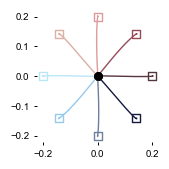

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


# Set global linewidth
# Style the Plot
plt.rcParams.update({
    "font.size": 7,
    "font.family": "Arial",
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    'lines.linewidth': 1,
    'axes.linewidth': 0.7,
    'xtick.major.width': 0.7,
    'xtick.minor.width': 0.7,
    'ytick.major.width': 0.7,
    'ytick.minor.width': 0.7,
    'xtick.major.size': 2.,  # Major xtick length
    'ytick.major.size': 2.,  # Minor xtick length
    "axes.titlesize": 7,  # Title font size
    "axes.titleweight": "bold",  # Title font weight
})


# RdPuBu colormap
colors = ['#56353e', '#954c57',  '#de9a9b', '#dcb0a3', '#bbe6f7', '#95c9ee', '#6e7e9f', '#141941']

cm = 1 / 2.54
fig = plt.figure(figsize=(4 * cm, 4 * cm), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# Panel 1: 2D hand path (spans 2 rows, 2 columns)
ax1 = fig.add_subplot(gs[0:2, 0:2])


num_points = 8
radius = 0.2
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
points = [(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles]

for c in range(8):
    ax1.plot(body_states_dict[exemplar_network_id][:160, c, 0], body_states_dict[exemplar_network_id][:160, c, 4], color=colors[c])
    point = points[c]
    ax1.scatter(*point, color=colors[c], marker='s', s=30, facecolors='white')
    ax1.plot(0, 0, color='black', marker='o', markersize=5)
sns.despine(top=True, right=True, ax=ax1)
sns.despine(ax=ax1, left=True, bottom=True)



plt.show()



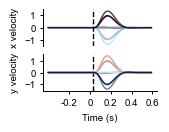

In [13]:
# Set global linewidth
# Style the Plot
plt.rcParams.update({
    "font.size": 7,
    "font.family": "Arial",
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    'lines.linewidth': 1,
    'axes.linewidth': 0.7,
    'xtick.major.width': 0.7,
    'xtick.minor.width': 0.7,
    'ytick.major.width': 0.7,
    'ytick.minor.width': 0.7,
    'xtick.major.size': 2.,  # Major xtick length
    'ytick.major.size': 2.,  # Minor xtick length
    "axes.titlesize": 7,  # Title font size
    "axes.titleweight": "bold",  # Title font weight
})


cm = 1 / 2.54
fig = plt.figure(figsize=(4 * cm, 4 * cm), constrained_layout=True)
gs = fig.add_gridspec(3, 2)



# Panel 2: y velocity (middle row, both columns)
ax2 = fig.add_subplot(gs[0, :])

# Panel 3: x velocity (bottom row, both columns)
ax3 = fig.add_subplot(gs[1, :])

num_points = 8
radius = 0.2
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
points = [(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles]


for c in range(8):
    ax2.plot(body_states_dict[exemplar_network_id][60:160, c, 1], color=colors[c])
ax2.axvline(x=43, color='k', linestyle='--')
ax2.set_xticks([20, 40, 60, 80, 100])
ax2.set_xticklabels(['-0.2', '0', '0.2', '0.4', '0.6'])
sns.despine(top=True, right=True, bottom=True, ax=ax2)
ax2.set_ylabel('x velocity')
ax2.tick_params(labelbottom=False, bottom=False, labelleft=True, left=True)

ax3.axvline(x=43, color='black', linestyle='--')
for j in range(8):
    ax3.plot(body_states_dict[exemplar_network_id][60:160, j, 5], color=colors[j])
ax3.set_ylabel('y velocity')
ax3.set_xlabel('Time (s)')
ax3.set_xticks([20, 40, 60, 80, 100])
ax3.set_xticklabels(['-0.2', '0', '0.2', '0.4', '0.6'])
sns.despine(ax=ax3, left=False, bottom=False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(labelbottom=True, bottom=True, labelleft=True, left=True)


plt.show()



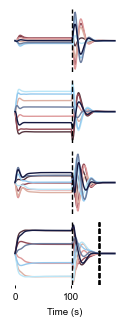

In [14]:

# figure with 4 subplots in a 2x2 grid, 4 neuron activity plots
fig = plt.figure(figsize=(3*cm, 8*cm), constrained_layout=True)
gs = fig.add_gridspec(4, 1)

# Panel 4: Neuron activity 1
ax4 = fig.add_subplot(gs[0, 0])
# Panel 5: Neuron activity 2
ax5 = fig.add_subplot(gs[1, 0])
# Panel 6: Neuron activity 3
ax6 = fig.add_subplot(gs[2, 0])
# Panel 7: Neuron activity 4
ax7 = fig.add_subplot(gs[3, 0])

neuron_indices = [24, 94, 34, 61]
#neuron_indices = [99, 94, 29, 21] # 31, 61, 86
# 21 looks good
for i in range(4):
    neuron_index = np.random.randint(0, 100)
    neuron_index = neuron_indices[i]
    # Use the bright color for each plot from the defined palette
    for j in range(8):
        if i == 0:
            ax4.plot(neuron_states_dict[exemplar_network_id][:180, j, neuron_index], color=colors[j])
            cur_axis = ax4
        elif i == 1:
            ax5.plot(neuron_states_dict[exemplar_network_id][:180, j, neuron_index], color=colors[j])
            cur_axis = ax5
        elif i == 2:
            ax6.plot(neuron_states_dict[exemplar_network_id][:180, j, neuron_index], color=colors[j])
            cur_axis = ax6
        elif i == 3:
            ax7.plot(neuron_states_dict[exemplar_network_id][:180, j, neuron_index], color=colors[j])
            cur_axis = ax7
            ax7.axvline(x=150, color='black', linestyle='--')
    
    cur_axis.tick_params(labelleft=False, left=False)  # Hide y-axis ticks labels

    sns.despine(ax=cur_axis, left=True, bottom=True)
    cur_axis.tick_params(labelbottom=False, bottom=False)

    # Draw a vertical line at t=103 for the "GO" signal on each subplot
    cur_axis.axvline(x=103, color='black', linestyle='--')
    if i == 3:
        cur_axis.tick_params(labelbottom=True, bottom=True)  # Show x-axis ticks labels only for the last subplot
        cur_axis.set_xlabel('Time (s)')
    else:
        cur_axis.tick_params(labelbottom=False, bottom=False)
    
    
plt.show()


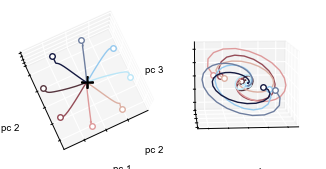

In [15]:



# figure with 3D pca trajectory prep and movement phases in two panels
fig = plt.figure(figsize=(8*cm, 4*cm), constrained_layout=True)
gs = fig.add_gridspec(1, 2)
# Panel 8: 3D PCA trajectory - prep phase
ax8 = fig.add_subplot(gs[0, 0], projection='3d')
# Panel 9: 3D PCA trajectory - movement phase
ax9 = fig.add_subplot(gs[0, 1], projection='3d')

# no axis tick labels
ax8.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
ax9.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
# increase tick width
ax8.tick_params(width=1)
ax9.tick_params(width=1)

# for ax8 plot the full_pc_data in 3D plot for the first 3 PCs
for c in range(8):
    x = pc_data_prep[:, c, 0]
    y = pc_data_prep[:, c, 1]
    z = pc_data_prep[:, c, 2]
    line, = ax8.plot(x, y, z, color=colors[c])   
    ax8.plot(x[0], y[0], z[0], 
             color='black', marker='+', markersize=8)  
    ax8.plot(x[-1], y[-1], z[-1], 
             color=colors[c], marker='o', markersize=4, markerfacecolor='white', markeredgecolor=colors[c])
ax8.set_xlabel('pc 1')
ax8.set_ylabel('pc 2')
ax8.set_zlabel('pc 3')
ax8.view_init(elev=80, azim=-115)
ax8.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)  # Hide y-axis ticks labels
# Customize grid lines
ax8.grid(True)
ax8.xaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax8.yaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax8.zaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
sns.despine(top = True, right = True, ax=ax8)

# for ax9 plot the full_pc_data in 3D plot for the first 3 PCs
for c in range(8):
    x = pc_data[:30, c, 0]
    y = pc_data[:30, c, 1]
    z = pc_data[:30, c, 2]
    line, = ax9.plot(x, y, z, color=colors[c])   
    ax9.plot(x[0], y[0], z[0], 
             color=colors[c], marker='o', markersize=4, markerfacecolor='white', markeredgecolor=colors[c])
    # Calculate the direction vector for the arrow
    if len(x) > 1:  # Ensure there are at least two points to calculate direction
        dx = x[-1] - x[-2]
        dy = y[-1] - y[-2]
        dz = z[-1] - z[-2]

        # Plot the arrow using quiver
        ax9.quiver(x[-2], y[-2], z[-2], dx, dy, dz, color=colors[c], arrow_length_ratio=1.5, linewidth=1)
ax9.set_xlabel('pc 1')
ax9.set_ylabel('pc 2')
ax9.set_zlabel('pc 3')
ax9.view_init(elev=9, azim=-95)
# remove axis ticklabels
# remove gridlines
ax9.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)  # Hide y-axis ticks labels
# Customize grid lines
ax9.grid(True)
ax9.xaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax9.yaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
ax9.zaxis._axinfo['grid'].update(color='w', linestyle='-', linewidth=0.8)
sns.despine(top = True, right = True, ax=ax9)

plt.show()

In [16]:
# save the 3D plot contents as .mat file
import scipy
scipy.io.savemat('3d_pca_figure.mat', {'pc_data': pc_data, 'pc_data_prep': pc_data_prep})


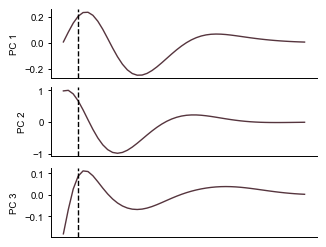

In [17]:
# plot the 3 PCs as 2D subplots over time, beautiful plots
fig = plt.figure(figsize=(8*cm, 6*cm), constrained_layout=True)
gs = fig.add_gridspec(3, 1)
# Panel 10: PC 1 over time
ax10 = fig.add_subplot(gs[0, 0])
# Panel 11: PC 2 over time
ax11 = fig.add_subplot(gs[1, 0])
# Panel 12: PC 3 over time
ax12 = fig.add_subplot(gs[2, 0])

for c in range(1):
    ax10.plot(pc_data[:50, c, 0], color=colors[c])
    ax11.plot(pc_data[:50, c, 1], color=colors[c])
    ax12.plot(pc_data[:50, c, 2], color=colors[c])
    ax10.axvline(x=3, color='k', linestyle='--')
    ax11.axvline(x=3, color='k', linestyle='--')
    ax12.axvline(x=3, color='k', linestyle='--')
    sns.despine(top=True, right=True, ax=ax10)
    sns.despine(top=True, right=True, ax=ax11)
    sns.despine(top=True, right=True, ax=ax12)
    ax10.tick_params(labelbottom=False, bottom=False)  # Hide x-axis ticks labels
    ax11.tick_params(labelbottom=False, bottom=False)  # Hide x-axis ticks labels
    ax12.tick_params(labelbottom=False, bottom=False)  # Hide x-axis ticks labels
    if c == 7:
        ax12.tick_params(labelbottom=True, bottom=True)  # Show x-axis ticks labels only for the last subplot
        ax12.set_xlabel('Time (s)')
    else:
        ax12.tick_params(labelbottom=False, bottom=False)
    ax10.set_ylabel('PC 1')
    ax11.set_ylabel('PC 2')
    ax12.set_ylabel('PC 3')


Number of PCs to explain 95% variance: 4


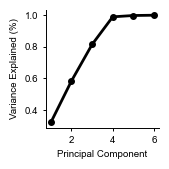

In [18]:
# plot the variance explained by each of the first 20 PCs, and add a vertical line where 90% variance is explained
explained_variance = pca_instance.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
# find when the cumulative variance exceeds 80%
threshold_index = np.where(cumulative_variance >= 0.95)[0][0]
print('Number of PCs to explain 95% variance:', threshold_index + 1)

fig2 = plt.figure(figsize=(4*cm, 4*cm), constrained_layout=True)
gs2 = fig2.add_gridspec(1, 1)
# Panel 13: Variance explained by PCs
ax13 = fig2.add_subplot(gs2[0, 0])
ax13.plot(range(1, 7), cumulative_variance[:6], 'k-', linewidth=2, marker='o', markersize=4)
ax13.set_xlabel('Principal Component')
ax13.set_ylabel('Variance Explained (%)')
sns.despine(top=True, right=True, ax=ax13)

cross condition mean of 5 neurons pre processing is: [-5.02361789e-13 -9.71570299e-13  4.75054339e-13 -1.32067286e-12
 -3.81028542e-13] 

cross condition mean of 5 neurons post processing is: [ 4.54182146e-18 -5.04646829e-18 -2.52323415e-18 -4.03717464e-18
 -1.00929366e-18]
cross condition mean of 5 neurons pre processing is: [7.54024064 2.85035547 0.5777759  4.3606965  0.24893642] 

cross condition mean of 5 neurons post processing is: [1.41301112e-17 0.00000000e+00 5.04646829e-19 5.04646829e-18
 1.26161707e-19]
cross condition mean of 5 neurons pre processing is: [17.77188818 14.86232663 71.61887119  4.33516757 25.97306211] 

cross condition mean of 5 neurons post processing is: [ 1.29526020e-17 -1.11022302e-17  3.33066907e-17  4.62592927e-18
 -2.03540888e-17]


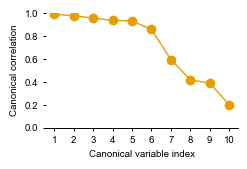

Mean of top canonical correlations between Churchland2012 and Hari2020: 0.7267692539911248
AUC of canonical correlations between Churchland2012 and Hari2020: 6.690178495879399


In [19]:
nature_palette = [ "#E69F00FF", "#E64B35FF", "#3C5488FF"]  # blue, orange, red

# there are three files named analysis_scripts_for_Hari/comparision_1.mat, analysis_scripts_for_Hari/comparision_2.mat, analysis_scripts_for_Hari/comparision_3.mat
# load them and extract the variables inside and print them
data1 = scipy.io.loadmat('analysis_scripts_for_Hari/comparison_1.mat')
data2 = scipy.io.loadmat('analysis_scripts_for_Hari/comparison_2.mat')
data3 = scipy.io.loadmat('analysis_scripts_for_Hari/comparison_3.mat')

cut_data_hari = data1['save_datas'][100:155, :8, :100]
cut_data_church = data2['save_datas'][0:55, :8, :100]
cut_data_kevin = data3['save_datas'][0:55, :8, :100]

pc_data_hari, pca_instance_hari = compute_pca_and_projection(cut_data_hari, args, [5,15], [0,40])
pc_data_church, pca_instance_church = compute_pca_and_projection(cut_data_church, args, [5,15], [0,40])
pc_data_kevin, pca_instance_kevin = compute_pca_and_projection(cut_data_kevin, args, [5,15], [0,30])

# compute canonical correlation between church and hari, kevin and hari
from sklearn.cross_decomposition import CCA
numccs = 10
cca_church_hari = CCA(n_components=numccs)
cca_kevin_hari = CCA(n_components=numccs)
cca_church_kevin = CCA(n_components=numccs)
cca_church_hari.fit(pc_data_church.reshape(-1, pc_data_church.shape[-1]), pc_data_hari.reshape(-1, pc_data_hari.shape[-1]))
#cca_kevin_hari.fit(pc_data_kevin.reshape(-1, pc_data_kevin.shape[-1]), pc_data_hari.reshape(-1, pc_data_hari.shape[-1]))
#cca_church_kevin.fit(pc_data_church.reshape(-1, pc_data_church.shape[-1]), pc_data_kevin.reshape(-1, pc_data_kevin.shape[-1]))
#
X_c, Y_c = cca_church_hari.transform(pc_data_church.reshape(-1, pc_data_church.shape[-1]), pc_data_hari.reshape(-1, pc_data_hari.shape[-1]))
#X_k, Y_k = cca_kevin_hari.transform(pc_data_kevin.reshape(-1, pc_data_kevin.shape[-1]), pc_data_hari.reshape(-1, pc_data_hari.shape[-1]))
#X_ck, Y_ck = cca_church_kevin.transform(pc_data_church.reshape(-1, pc_data_church.shape[-1]), pc_data_kevin.reshape(-1, pc_data_kevin.shape[-1]))
# compute the correlation coefficient between each pair of canonical variables
corrs_church_hari = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]
#corrs_kevin_hari = [np.corrcoef(X_k[:, i], Y_k[:, i])[0, 1] for i in range(X_k.shape[1])]
#corrs_church_kevin = [np.corrcoef(X_ck[:, i], Y_ck[:, i])[0, 1] for i in range(X_ck.shape[1])]

# plot the top 6 correlation coefficients in a line plot
fig = plt.figure(figsize=(6*cm, 4*cm), constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
x = np.arange(1, numccs+1)
ax.plot(x, corrs_church_hari, marker='o', color=nature_palette[0], label='Churchland2012')
#ax.plot(x, corrs_kevin_hari, marker='s', color=nature_palette[1], label='Kalidindi2021')
#ax.plot(x, corrs_church_kevin, marker='^', color=nature_palette[2], label='Churchland2012 vs Kalidindi2021')
ax.set_xticks(x)
ax.set_xticklabels([str(i) for i in x])
ax.set_ylabel('Canonical correlation', fontsize=7)
ax.set_xlabel('Canonical variable index', fontsize=7)
ax.set_ylim(0, 1)
sns.despine(top=True, right=True, ax=ax)
ax.spines['left'].set_visible(False)
ax.tick_params(labelleft=True, left=True)
ax.tick_params(labelbottom=True, bottom=True)
#plt.legend(loc='upper right', frameon=True, fontsize=7)
plt.show()

# print mean of top 10 correlation coefficients
print("Mean of top canonical correlations between Churchland2012 and Hari2020:", np.mean(corrs_church_hari[:]))
#print("Mean of top 10 canonical correlations between Kalidindi2021 and Hari2020:", np.mean(corrs_kevin_hari[:10]))
#print("Mean of top 10 canonical correlations between Churchland2012 and Kalidindi2021:", np.mean(corrs_church_kevin[:10]))

# compute area under the curve for the CCA correlation curves
from scipy.integrate import simpson
auc_church_hari = simpson(corrs_church_hari, x)
#auc_kevin_hari = simpson(corrs_kevin_hari, x)
#auc_church_kevin = simpson(corrs_church_kevin, x)
print("AUC of canonical correlations between Churchland2012 and Hari2020:", auc_church_hari)
#print("AUC of canonical correlations between Kalidindi2021 and Hari2020:", auc_kevin_hari)
#print("AUC of canonical correlations between Churchland2012 and Kalidindi2021:", auc_church_kevin)

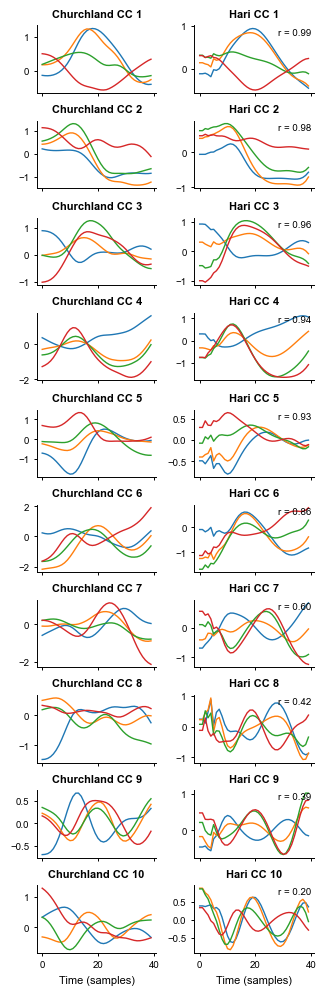

In [20]:
# plot the first 6 aligned CCs in a row and annotate each subplot with its correlation coefficient
# reshape X_c and Y_c back to (time, conditions, pcs)
X_c = X_c.reshape(pc_data_church.shape[0], pc_data_church.shape[1], -1)
Y_c = Y_c.reshape(pc_data_hari.shape[0], pc_data_hari.shape[1], -1)

# average across conditions to get (time, pcs)
Xc_mean = X_c.mean(axis=1)
Yc_mean = Y_c.mean(axis=1)

# number of CCs to plot
n_cc = min(10, Xc_mean.shape[1], Yc_mean.shape[1], len(corrs_church_hari))

# figure: n_cc rows x 2 columns (Churchland | Hari)
cm = globals().get('cm', 1/2.54)
fig, axs = plt.subplots(n_cc, 2, figsize=(8 * cm, n_cc * 2.5 * cm), constrained_layout=True)

# normalize axs shape for consistent indexing
if n_cc == 1:
    axs = axs.reshape(1, 2)

for i in range(n_cc):
    r = corrs_church_hari[i]
    ax_left = axs[i, 0]
    ax_right = axs[i, 1]

    # plot Churchland (left) and Hari (right) canonical time courses (averaged across conditions)
    ax_left.plot(X_c[:, :4, i])
    ax_right.plot(Y_c[:, :4, i])

    # titles and annotation with correlation
    ax_left.set_title(f'Churchland CC {i+1}', fontsize=8)
    ax_right.set_title(f'Hari CC {i+1}', fontsize=8)
    #ax_left.text(0.98, 0.9, f'r = {r:.2f}', transform=ax_left.transAxes, ha='right', va='center', fontsize=7)
    ax_right.text(0.98, 0.9, f'r = {r:.2f}', transform=ax_right.transAxes, ha='right', va='center', fontsize=7)

    sns.despine(top=True, right=True, ax=ax_left)
    sns.despine(top=True, right=True, ax=ax_right)

    # hide x labels for all but last row
    if i < n_cc - 1:
        ax_left.tick_params(labelbottom=False)
        ax_right.tick_params(labelbottom=False)

# shared x-label on bottom row
axs[-1, 0].set_xlabel('Time (samples)', fontsize=8)
axs[-1, 1].set_xlabel('Time (samples)', fontsize=8)

plt.show()

plt.show()

/var/folders/xg/sxw_vt8918l_815ffsp20_4w0000gp/T/ipykernel_56242/4014426393.py:12: UserWarning:

The figure layout has changed to tight



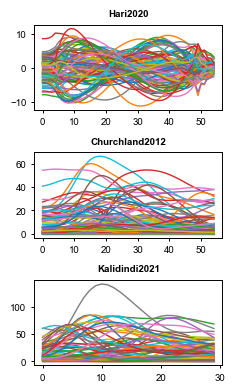

In [21]:
fig = plt.figure(figsize=(6*cm, 10*cm), constrained_layout=True)

plt.subplot(3, 1, 1)
plt.plot(cut_data_hari[:, 0, :])
plt.title('Hari2020')
plt.subplot(3, 1, 2)
plt.plot(cut_data_church[:, 0, :])
plt.title('Churchland2012')
plt.subplot(3, 1, 3)
plt.plot(cut_data_kevin[:, 0, :])
plt.title('Kalidindi2021')
plt.tight_layout()
plt.show()